In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
from sklearn.exceptions import ConvergenceWarning
from sklearn import model_selection, preprocessing, metrics
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNetCV, LassoLarsCV, OrthogonalMatchingPursuitCV
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.utils import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint
import time
import xgboost as xgb
import csv
import pickle
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
warnings.filterwarnings("ignore", category=ConvergenceWarning)

/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
RAW_DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/raw_data'
DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data'
TRAIN_DATA = os.path.join(RAW_DATA_PATH, 'train.csv')
TEST_DATA = os.path.join(RAW_DATA_PATH, 'test.csv')
SAMPLE_SUBMISSION = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')
MODELS_PATH = os.path.join(DATA_PATH, 'models')

In [3]:
train_df = pd.read_csv(TRAIN_DATA)
test_df = pd.read_csv(TEST_DATA)
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION)

In [4]:
filter_outliers = False
xgb_use_augment_features = False
stacked_use_augment_features = False

# Preprocess data
for column in train_df.columns:
    cardinality = len(np.unique(train_df[column]))
    if cardinality == 1:
        train_df.drop(column, axis=1, inplace=True)
        test_df.drop(column, axis=1, inplace=True)

original_train_columns = sorted(list(set(train_df.columns) - set(['ID', 'y'])))
        
for f in ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
    lbl = preprocessing.LabelEncoder()
    train_values = set(train_df[f].values)
    test_values = set(test_df[f].values)
    all_values = list(train_values | test_values)
    lbl.fit(all_values) 
    train_df[f] = lbl.transform(list(train_df[f].values))
    test_df[f] = lbl.transform(list(test_df[f].values))

if filter_outliers:
    print('Filtering outliers')
    # Filter out outlier y = 265.32
    train_df = train_df[train_df.y < 200]

print('train_df.shape', train_df.shape)
print('test_df.shape', test_df.shape)
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train_df.drop(["y"], axis=1))
tsvd_results_test = tsvd.transform(test_df)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train_df.drop(["y"], axis=1))
pca2_results_test = pca.transform(test_df)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train_df.drop(["y"], axis=1))
ica2_results_test = ica.transform(test_df)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train_df.drop(["y"], axis=1))
grp_results_test = grp.transform(test_df)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(train_df.drop(["y"], axis=1))
srp_results_test = srp.transform(test_df)

# Append decomposition components to datasets
for i in range(0, n_comp):
    train_df['pca_' + str(i)] = pca2_results_train[:, i]
    test_df['pca_' + str(i)] = pca2_results_test[:, i]

    train_df['ica_' + str(i)] = ica2_results_train[:, i]
    test_df['ica_' + str(i)] = ica2_results_test[:, i]

    train_df['tsvd_' + str(i)] = tsvd_results_train[:, i]
    test_df['tsvd_' + str(i)] = tsvd_results_test[:, i]

    train_df['grp_' + str(i)] = grp_results_train[:, i]
    test_df['grp_' + str(i)] = grp_results_test[:, i]

    train_df['srp_' + str(i)] = srp_results_train[:, i]
    test_df['srp_' + str(i)] = srp_results_test[:, i]

augmented_train_columns = sorted(list(set(train_df.columns) - set(['ID', 'y'])))
print('original columns', len(original_train_columns))
print('augmented columns', len(augmented_train_columns))
print('train_df.shape', train_df.shape)
print('test_df.shape', test_df.shape)

train_df.shape (4209, 366)
test_df.shape (4209, 365)
original columns 364
augmented columns 424
train_df.shape (4209, 426)
test_df.shape (4209, 425)


In [5]:
X = train_df.drop(["ID", "y"], axis=1)
Y = train_df['y'].values

train_X, holdout_X, train_Y, holdout_Y = model_selection.train_test_split(X, Y, test_size=0.2, random_state=29)
print('X.shape', X.shape)
print('Y.shape', Y.shape)
print('train_X.shape', train_X.shape)
print('train_Y.shape', train_Y.shape)
print('holdout_X.shape', holdout_X.shape)
print('holdout_Y.shape', holdout_Y.shape)

X.shape (4209, 424)
Y.shape (4209,)
train_X.shape (3367, 424)
train_Y.shape (3367,)
holdout_X.shape (842, 424)
holdout_Y.shape (842,)


In [6]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
#         if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
#             X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))
        return X_transformed

NUM_FOLDS = 10
kf = model_selection.KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
perf = []

if stacked_use_augment_features:
    train_X_stacked = train_X[augmented_train_columns]
    holdout_X_stacked = holdout_X[augmented_train_columns]
    test_X_stacked = test_df[augmented_train_columns]
else:
    train_X_stacked = train_X[original_train_columns]
    holdout_X_stacked = holdout_X[original_train_columns]
    test_X_stacked = test_df[original_train_columns]

print('train_X_stacked.shape', train_X_stacked.shape)
print('train_Y.shape', train_Y.shape)
print('holdout_X_stacked.shape', holdout_X_stacked.shape)
print('holdout_Y.shape', holdout_Y.shape)

for fold, (train_idxs, val_idxs) in enumerate(kf.split(train_X_stacked)):
    model_id = "model-" + str(int(time.time()))
    print('Fold {} Training {}'.format(fold, model_id))
    
    trn_X_stacked, val_X_stacked = train_X_stacked.iloc[train_idxs], train_X_stacked.iloc[val_idxs]
    trn_Y_stacked, val_Y_stacked = train_Y[train_idxs], train_Y[val_idxs]
    
    stacked_pipeline = make_pipeline(
        StackingEstimator(estimator=LassoLarsCV(normalize=True)),
        StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber",
                                                              n_estimators=500, max_depth=3,
                                                              max_features=0.55, min_samples_leaf=18,
                                                              min_samples_split=14, subsample=0.7)),
#         ExtraTreesRegressor(n_estimators=500, max_features=0.55,
#                             max_depth=3, min_samples_leaf=18,
#                             min_samples_split=14, n_jobs=-1),
        LassoLarsCV())
    stacked_pipeline.fit(trn_X_stacked, trn_Y_stacked)
    pickle.dump(stacked_pipeline, open(os.path.join(MODELS_PATH, model_id + ".stacked"), "wb"))
    train_Y_stacked_pred = stacked_pipeline.predict(trn_X_stacked)
    train_r2_score = metrics.r2_score(trn_Y_stacked, train_Y_stacked_pred)
    val_Y_stacked_pred = stacked_pipeline.predict(val_X_stacked)
    val_r2_score = metrics.r2_score(val_Y_stacked, val_Y_stacked_pred)
    holdout_Y_pred = stacked_pipeline.predict(holdout_X_stacked)
    holdout_r2_score = metrics.r2_score(holdout_Y, holdout_Y_pred)
    perf.append((fold, model_id, train_r2_score, val_r2_score, holdout_r2_score))

perf_stacked_df = pd.DataFrame(perf, columns=['fold', 'model_id', 'train_r2', 'validation_r2', 'holdout_r2'])
print('avg train r2', perf_stacked_df['train_r2'].mean(),
      'avg validation r2', perf_stacked_df['validation_r2'].mean(), 
      'avg holdout r2', perf_stacked_df['holdout_r2'].mean())
perf_stacked_df

train_X_stacked.shape (3367, 364)
train_Y.shape (3367,)
holdout_X_stacked.shape (842, 364)
holdout_Y.shape (842,)
Fold 0 Training model-1498155476


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 1 Training model-1498155484


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 2 Training model-1498155493


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 3 Training model-1498155501


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 4 Training model-1498155510


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 5 Training model-1498155518


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 6 Training model-1498155526


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 7 Training model-1498155535


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 8 Training model-1498155543


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


Fold 9 Training model-1498155552


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


avg train r2 0.604376956902 avg validation r2 0.588825284337 avg holdout r2 0.472281021469


,fold,model_id,train_r2,validation_r2,holdout_r2
0,0,model-1498155476,0.602573,0.578471,0.471054
1,1,model-1498155484,0.607156,0.577646,0.474077
2,2,model-1498155493,0.601935,0.612002,0.472678
3,3,model-1498155501,0.601419,0.643673,0.473711
4,4,model-1498155510,0.609966,0.482206,0.471269
5,5,model-1498155518,0.602180,0.520987,0.463600
6,6,model-1498155526,0.605944,0.576415,0.474511
7,7,model-1498155535,0.603221,0.623827,0.473929
8,8,model-1498155543,0.608588,0.604192,0.476211
9,9,model-1498155552,0.600788,0.668833,0.471769


In [7]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prodiction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))
        return X_transformed

if stacked_use_augment_features:
    train_X_stacked = train_X[augmented_train_columns]
    holdout_X_stacked = holdout_X[augmented_train_columns]
    test_X_stacked = test_df[augmented_train_columns]
else:
    train_X_stacked = train_X[original_train_columns]
    holdout_X_stacked = holdout_X[original_train_columns]
    test_X_stacked = test_df[original_train_columns]

print('train_X_stacked.shape', train_X_stacked.shape)
print('train_Y.shape', train_Y.shape)
print('holdout_X_stacked.shape', holdout_X_stacked.shape)
print('holdout_Y.shape', holdout_Y.shape)

stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber",
                                                          n_estimators=500, max_depth=3,
                                                          max_features=0.55, min_samples_leaf=18,
                                                          min_samples_split=14, subsample=0.7)),
    LassoLarsCV())
stacked_pipeline.fit(train_X_stacked, train_Y)
train_Y_stacked_pred = stacked_pipeline.predict(train_X_stacked)
train_r2_score = metrics.r2_score(train_Y, train_Y_stacked_pred)
holdout_Y_stacked_pred = stacked_pipeline.predict(holdout_X_stacked)
holdout_r2_score = metrics.r2_score(holdout_Y, holdout_Y_stacked_pred)

print('train R2', train_r2_score, 'holdout R2', holdout_r2_score)

train_X_stacked.shape (3367, 364)
train_Y.shape (3367,)
holdout_X_stacked.shape (842, 364)
holdout_Y.shape (842,)


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))
/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))


train R2 0.600813720279 holdout R2 0.472821763031


In [36]:
NUM_FOLDS = 10
kf = model_selection.KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
perf = []

train_X_original_columns = train_X[original_train_columns]
holdout_X_original_columns = holdout_X[original_train_columns]

if xgb_use_augment_features:
    train_X_xgb = train_X[augmented_train_columns]
    test_X_xgb = test_df[augmented_train_columns]
    holdout_X_xgb = holdout_X[augmented_train_columns]
else:
    train_X_xgb = train_X[original_train_columns]
    test_X_xgb = test_df[original_train_columns]
    holdout_X_xgb = holdout_X[original_train_columns]

print('train_X_xgb.shape', train_X_xgb.shape)
print('train_Y.shape', train_Y.shape)
print('holdout_X_xgb.shape', holdout_X_xgb.shape)
print('holdout_Y.shape', holdout_Y.shape)
print('test_X_xgb.shape', test_X_xgb.shape, '\n')

for fold, (train_idxs, val_idxs) in enumerate(kf.split(train_X_xgb)):
    model_id = "model-" + str(int(time.time()))
    print('Fold {} Training {}'.format(fold, model_id))
    
    trn_X, val_X = train_X_xgb.iloc[train_idxs], train_X_xgb.iloc[val_idxs]
    trn_Y, val_Y = train_Y[train_idxs], train_Y[val_idxs]

    def xgb_r2_score(preds, dtrain):
        labels = dtrain.get_label()
        return 'rmse', -1.0 * metrics.r2_score(labels, preds)

    model = xgb.XGBRegressor(max_depth = 10,
                        gamma=0.5,
                        objective="reg:linear",
                        n_estimators=1000,
                        learning_rate=0.005,
                        nthread=12,
                        subsample=0.8,
                        colsample_bytree=0.70,
                        colsample_bylevel=0.70,
                        #base_score=Y_mean,
                        seed=42,
                        silent=True)

    model.fit(trn_X, trn_Y, eval_set=[(trn_X, trn_Y), (val_X, val_Y)], verbose=False, eval_metric='rmse', early_stopping_rounds=50)
    evals_result = model.evals_result()
    pickle.dump(model, open(os.path.join(MODELS_PATH, model_id + ".xgb"), "wb"))
    train_Y_pred = model.predict(trn_X)
    train_r2_score = metrics.r2_score(trn_Y, train_Y_pred)
    val_Y_pred = model.predict(val_X)
    val_r2_score = metrics.r2_score(val_Y, val_Y_pred)
    holdout_Y_pred = model.predict(holdout_X_xgb)
    holdout_r2_score = metrics.r2_score(holdout_Y, holdout_Y_pred)
    perf.append((fold, model_id, train_r2_score, val_r2_score, holdout_r2_score))

perf_df = pd.DataFrame(perf, columns=['fold', 'model_id', 'train_r2', 'validation_r2', 'holdout_r2'])
print('avg train r2', perf_df['train_r2'].mean(),
      'avg validation r2', perf_df['validation_r2'].mean(), 
      'avg holdout r2', perf_df['holdout_r2'].mean())
perf_df

train_X_xgb.shape (3367, 364)
train_Y.shape (3367,)
holdout_X_xgb.shape (842, 364)
holdout_Y.shape (842,)
test_X_xgb.shape (4209, 364) 

Fold 0 Training model-1498099872
Fold 1 Training model-1498099876
Fold 2 Training model-1498099880
Fold 3 Training model-1498099883
Fold 4 Training model-1498099887
Fold 5 Training model-1498099890
Fold 6 Training model-1498099894
Fold 7 Training model-1498099898
Fold 8 Training model-1498099903
Fold 9 Training model-1498099907
avg train r2 0.785553737964 avg validation r2 0.573319566483 avg holdout r2 0.457755112673


,fold,model_id,train_r2,validation_r2,holdout_r2
0,0,model-1498099872,0.779920,0.582531,0.457866
1,1,model-1498099876,0.794864,0.540561,0.458819
2,2,model-1498099880,0.775078,0.594724,0.460139
3,3,model-1498099883,0.775889,0.640542,0.457974
4,4,model-1498099887,0.789967,0.446044,0.459537
5,5,model-1498099890,0.807411,0.528380,0.449457
6,6,model-1498099894,0.788538,0.536388,0.451634
7,7,model-1498099898,0.780205,0.616906,0.460785
8,8,model-1498099903,0.784827,0.593916,0.460195
9,9,model-1498099907,0.778838,0.653204,0.461145


In [10]:
# Avg xgb models predictions
VALIDATION_THRESHOLD = 0.4
NUM_MODELS = perf_df[perf_df.validation_r2 > VALIDATION_THRESHOLD].shape[0]
holdout_Y_pred = np.zeros(shape=(holdout_X.shape[0], NUM_MODELS), dtype=np.float32)
test_Y_pred = np.zeros(shape=(test_df.shape[0], NUM_MODELS), dtype=np.float32)

count = 0
for row in perf_df.itertuples():
    fold, model_id, train_r2, validation_r2 = row[1], row[2], row[3], row[4]
    if validation_r2 < VALIDATION_THRESHOLD:
        continue
    model = pickle.load(open(os.path.join(MODELS_PATH, model_id + '.xgb'), 'rb'))
    test_Y_pred[:, count] = model.predict(test_X_xgb)
    holdout_Y_pred[:, count] = model.predict(holdout_X_xgb)
    count += 1

holdout_Y_avg = np.mean(holdout_Y_pred, axis=1)
test_Y_avg = np.mean(test_Y_pred, axis=1)
test_Y_avg.shape

(4209,)

In [11]:
# Avg stacked models predictions
VALIDATION_THRESHOLD = 0.4
NUM_MODELS = perf_stacked_df[perf_stacked_df.validation_r2 > VALIDATION_THRESHOLD].shape[0]
holdout_Y_pred = np.zeros(shape=(holdout_X.shape[0], NUM_MODELS), dtype=np.float32)
test_Y_pred = np.zeros(shape=(test_df.shape[0], NUM_MODELS), dtype=np.float32)

count = 0
for row in perf_stacked_df.itertuples():
    fold, model_id, train_r2, validation_r2 = row[1], row[2], row[3], row[4]
    if validation_r2 < 0.4:
        continue
    model = pickle.load(open(os.path.join(MODELS_PATH, model_id + '.stacked'), 'rb'))
    test_Y_pred[:, count] = model.predict(test_X_stacked)
    holdout_Y_pred[:, count] = model.predict(holdout_X_stacked)
    count += 1

holdout_Y_avg_stacked = np.mean(holdout_Y_pred, axis=1)
test_Y_avg_stacked = np.mean(test_Y_pred, axis=1)
test_Y_avg_stacked.shape

NameError: name 'perf_stacked_df' is not defined

In [12]:
# Weighted average of predictions
holdout_Y_ensembled = holdout_Y_avg * 0.5 + holdout_Y_avg_stacked * 0.5
holdout_r2_ensemble = metrics.r2_score(holdout_Y, holdout_Y_ensembled)
print('holdout_r2_ensemble', holdout_r2_ensemble)

test_Y_ensemble_1 = test_Y_avg * 0.5 + test_Y_avg_stacked * 0.5
test_Y_ensemble_1.shape

NameError: name 'holdout_Y_avg_stacked' is not defined

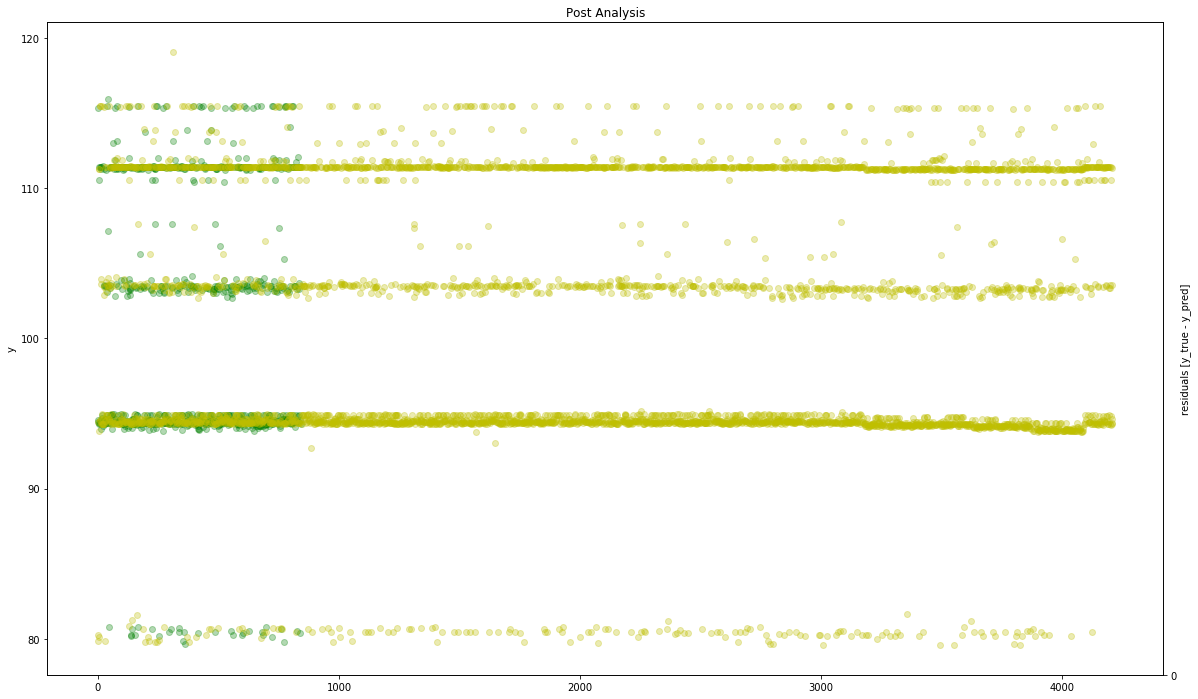

In [47]:
#post_analysis = val_x.copy()
post_analysis = pd.DataFrame()
post_analysis['y_pred'] = holdout_Y_stacked_pred#model.predict(val_x)
post_analysis['y_true'] = holdout_Y
post_analysis['residuals'] = post_analysis[['y_pred', 'y_true']].apply(lambda x: x['y_true'] - x['y_pred'], axis=1)

# graphing code
fig, ax1 = plt.subplots(figsize=(20,12))
ax2 = ax1.twinx()
plt.title('Post Analysis')
ax1.set_ylabel('y')
ax2.set_ylabel('residuals [y_true - y_pred]')
plt.xlabel('user_id')
#ax1.plot(post_analysis.index.values, post_analysis['y_true'],'ro', alpha=0.30)
ax1.plot(post_analysis.index.values, post_analysis['y_pred'],'go', alpha=0.30)
#ax2.plot(post_analysis.index.values, post_analysis['residuals'],'bv', alpha=0.50)
ax1.plot(range(len(stacked_Y)), stacked_Y,'yo', alpha=0.30)

ax1.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(10))
plt.show()

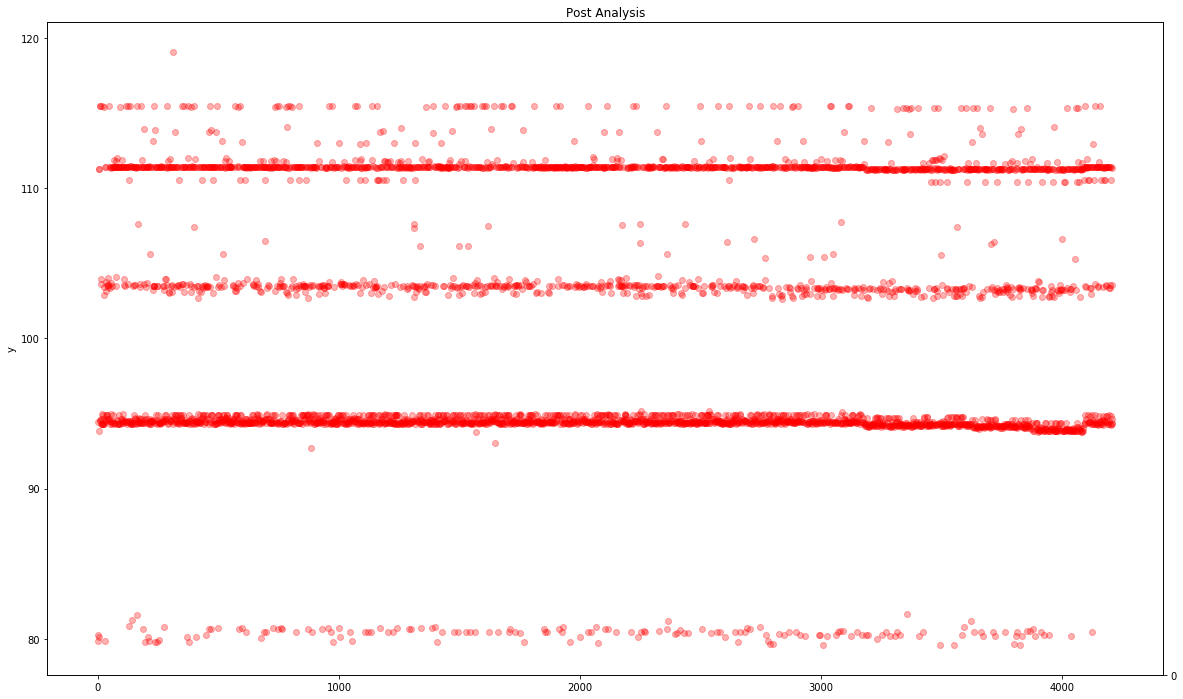

In [41]:
fig, ax1 = plt.subplots(figsize=(20,12))
ax2 = ax1.twinx()
plt.title('Post Analysis')
ax1.set_ylabel('y')
ax2.set_xlabel('row number')

ax1.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(10))
plt.show()

In [ ]:
post_analysis = pd.DataFrame()
post_analysis['y_pred'] = holdout_Y_pred#model.predict(val_x)
post_analysis['y_true'] = holdout_Y
post_analysis['residuals'] = post_analysis[['y_pred', 'y_true']].apply(lambda x: x['y_true'] - x['y_pred'], axis=1)
# graphing code
fig, ax1 = plt.subplots(figsize=(20,12))
ax2 = ax1.twinx()
plt.title('Post Analysis')
ax1.set_ylabel('y')
ax2.set_ylabel('residuals [y_true - y_pred]')
plt.xlabel('user_id')
ax1.plot(post_analysis.index.values, post_analysis['y_true'],'ro', alpha=0.30)

ax1.plot(post_analysis.index.values, post_analysis['y_pred'],'go', alpha=0.30)
ax1.plot(range(len(stacked_Y)), stacked_Y,'yo', alpha=0.30)

#ax2.plot(post_analysis.index.values, post_analysis['residuals'],'bv', alpha=0.50)
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(10))
plt.show()

In [40]:
stacked_Y

array([  80.26778634,   94.43694217,   79.86108056, ...,   94.32747916,
        111.36989835,   94.39385226])

In [74]:
post_analysis['y_true'].median()

119.65

In [57]:
post_analysis[post_analysis.residuals > 10]

,y_pred,y_true,residuals
1,93.373421,116.87,23.496579
5,113.677032,142.71,29.032968
25,103.426735,114.18,10.753265
32,94.764503,121.06,26.295497
38,94.127609,135.13,41.002391
57,93.616264,111.46,17.843736
68,115.516464,127.42,11.903536
91,113.921989,125.25,11.328011
92,94.140915,117.85,23.709085
98,92.746941,118.53,25.783059


In [39]:
# Weighted average of predictions
# holdout_Y_ensembled = holdout_Y_avg * 0.5 + holdout_Y_stacked_pred * 0.5
# holdout_r2_ensemble = metrics.r2_score(holdout_Y, holdout_Y_ensembled)
# print('holdout_r2_ensemble', holdout_r2_ensemble)

# Single stacked model prediction
test_X_xgb = test_df[augmented_train_columns]
stacked_Y = stacked_pipeline.predict(test_X_stacked)
# stacked_Y.shape
test_Y_ensemble_2 = test_Y_avg * 0.5 + stacked_Y * 0.5
test_Y_ensemble_2.shape

(4209,)

In [17]:
# Create submission file
submission_df = test_df[['ID']]
submission_df['y'] = test_Y_ensemble_2.tolist()
submission_df.to_csv(os.path.join(SUBMISSION_PATH, 'submission-' + str(int(time.time())) + '.csv'), index=False)
print('Generated submission ', os.path.join(SUBMISSION_PATH, 'submission-' + str(int(time.time())) + '.csv'))

Generated submission  /kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions/submission-1498059783.csv


/kaggle/dev/ashish/mercedes-benz-greener-manufacturing/merc/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
